In [ ]:
pip install wordcloud

In [ ]:
pip install --upgrade pillow

In [ ]:
pip install ydata-profiling==4.7.0

In [ ]:
pip install psycopg2-binary

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from pywaffle import Waffle
import matplotlib.cm as cm
import plotly.express as px
import warnings
warnings.simplefilter("ignore")
from wordcloud import WordCloud
import PIL
from ydata_profiling import ProfileReport
import psycopg2

In [2]:
file = pd.ExcelFile(r"C:\Users\OrganDonor_Consolidated.xlsx")
donor = pd.read_excel(file,'DonorDetails')
referral = pd.read_excel(file,"ReferralDetails")
outcomes = pd.read_excel(file,"Outcomes")
opo_hosp = pd.read_excel(file,'OPO_HospDetails')
yearly = pd.read_excel(file,"Yearly_Outcomes")

# Q1. Using numpy functions, multiply the following arrays using matrix multiplication.
 a=np.arange(4).reshape(2,2)
 b=np.arange(6).reshape(3,2)

In [3]:
a = np.arange(4).reshape(2,2)
b = np.arange(6).reshape(3,2)
#Since, for a multiplication to happen between a and b, the number of columns in a should be equal to number of rows in b.
#Hence, reshaping matrix b into (2,3)
b = b.reshape(2,3)
print('result of multiplication of a and b is: ',np.dot(a,b))

result of multiplication of a and b is:  [[ 3  4  5]
 [ 9 14 19]]


# Q2. On Average, what is the time that passes between approach and procurement?

In [4]:
referral['datediff'] = (pd.to_datetime(referral['time_procured'])-pd.to_datetime(referral['time_approached'])).dt.total_seconds()/3600
print('Average time between approach and procurement in hours is: ',round(referral['datediff'].mean(),2),'hrs')

Average time between approach and procurement in hours is:  87.76 hrs


# Q3. Plot the time series of Donor referrals with 5 month intervals between each.

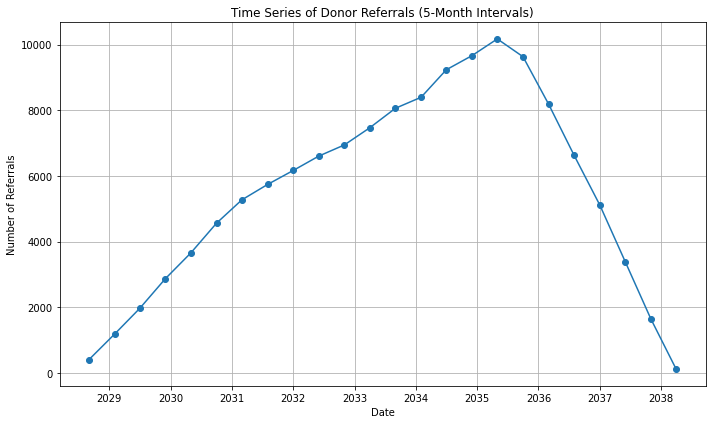

In [5]:
#Taking the time_referred column from referral sheet
time_referred = referral['time_referred'].dropna().reset_index(drop=True)
# Put this inside a dataframe
df = pd.DataFrame(time_referred)
# Convert the date strings to datetime objects
dates = pd.to_datetime(time_referred)
# Create a DataFrame with the dates
df = pd.DataFrame(dates, columns=["time_referred"])
# Resample the data in 5-month intervals, counting the number of referrals in each interval
df.set_index('time_referred', inplace=True)
df_resampled = df.resample('5MS').size()  # '5MS' = 5-month start frequency
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df_resampled.index, df_resampled.values, marker='o')
plt.title('Time Series of Donor Referrals (5-Month Intervals)')
plt.xlabel('Date')
plt.ylabel('Number of Referrals')
plt.grid(True)
plt.tight_layout()
plt.show()

# Q4. Who is the oldest patient who died of drug overdose?

In [6]:
drug_overdose_patient = donor[donor['causeofdeath']=='Drug Overdose']
oldest_patient = drug_overdose_patient.loc[drug_overdose_patient['age'].idxmax()]
print('The oldest patient that died of drug overdose is: ',oldest_patient)

The oldest patient that died of drug overdose is:  PatientID                    OPO5_P960496
age                                  74.0
gender                                  F
race                                White
causeofdeath                Drug Overdose
mechanism_of_death                Unknown
brain_death                             0
time_asystole         2035-11-05 05:45:00
time_brain_death                      NaT
Name: 120537, dtype: object


# Q5. What is the average age of patients with renal failure?

In [7]:
renal_failure_age = donor['age'][donor['causeofdeath']=='Renal  Disease']
print('Average age of patients with renal failure is: ',round(np.mean(renal_failure_age),2))

Average age of patients with renal failure is:  61.68


# Q6. List all male donors over 75 who had organs recovered for research

In [8]:
organ_research_patients = outcomes[(outcomes['outcome_heart']=='Recovered for Research')|
                                  (outcomes['outcome_intestine']=='Recovered for Research')|
                                  (outcomes['outcome_kidney_left']=='Recovered for Research')|
                                  (outcomes['outcome_kidney_right']=='Recovered for Research')|
                                  (outcomes['outcome_liver']=='Recovered for Research')|
                                  (outcomes['outcome_lung_left']=='Recovered for Research')|
                                  (outcomes['outcome_lung_right']=='Recovered for Research')|
                                  (outcomes['outcome_pancreas']=='Recovered for Research')]
donor1 = donor[['age','gender','PatientID']]
donor_organ_merge = pd.merge(donor1,organ_research_patients,on=['PatientID'])
male_over75_organs_recovered = donor_organ_merge[(donor_organ_merge['gender']=='M') & (donor_organ_merge['age']>75)]
male_over75_organs_recovered[['PatientID','age','gender']].style.hide_index()

# Q7. Make Patient ID as index to the table

In [9]:
donor_patientid_index = donor.set_index('PatientID')
print('donor details table with PatientID as index: ')
donor_patientid_index.head(2)

donor details table with PatientID as index: 


age gender      race causeofdeath mechanism_of_death  \
PatientID                                                             
OPO1_P155959  54.0      M     White      Unknown            Unknown   
OPO1_P297347  78.0      M  Hispanic      Unknown            Unknown   

              brain_death       time_asystole time_brain_death  
PatientID                                                       
OPO1_P155959            0 2036-01-02 18:26:00              NaT  
OPO1_P297347            0 2031-12-24 14:06:00              NaT

# Q8. Create a dictionary with the Age and Cause of Death for any 5 random donors.
 Access any one cause of death using the donors age using the get() function

In [10]:
age_cod_dict = {57:'Anoxia',
                18:'Head Trauma',
                62:'Cancer',
                32:'Meningitis',
                24:'Sepsis'}
cause_of_death = age_cod_dict.get(18)
print('cause of death for age 18 is',cause_of_death)

cause of death for age 18 is Head Trauma


# Q9. Create a heatmap on the donor details table.

<AxesSubplot:>

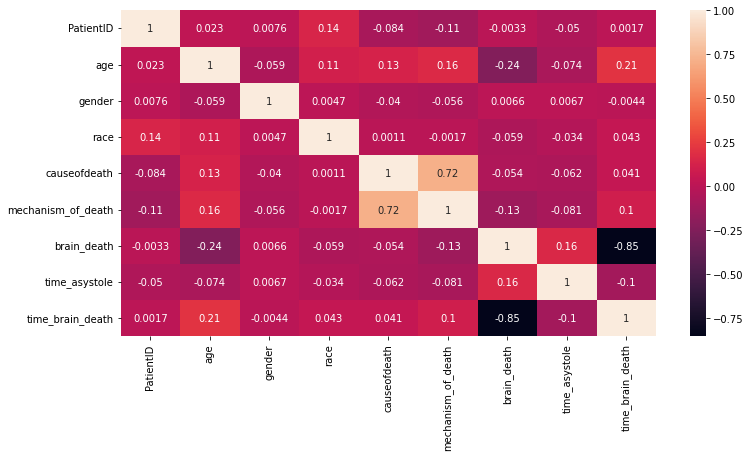

In [11]:
#Since the datatype of all columns in donor table was object, converting it into str
donor_str = donor.astype(str)

#Using label encoder to convert categorical columns into numerical
le = LabelEncoder()
donor_heatmap = donor_str.apply(le.fit_transform)

#Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(donor_heatmap.corr(),annot=True)

# Q10. Create a bar chart showing the number of donors by procured year. 
Add hatching to the bars using the set_hatch() method, and exclude any outlier years.

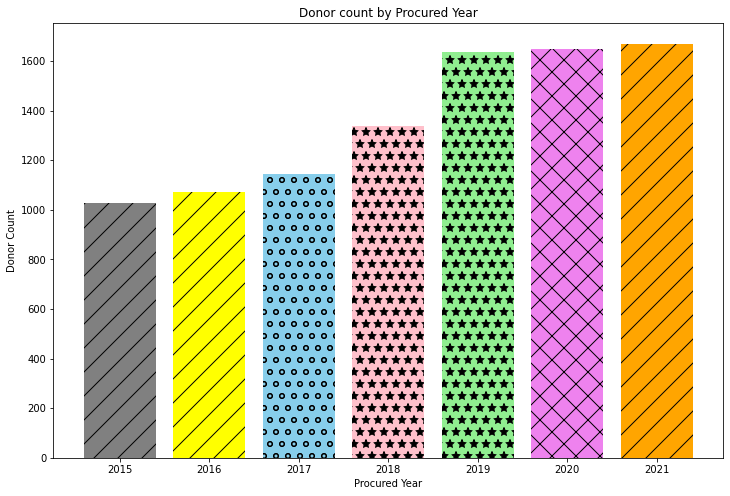

In [12]:
donor_count_yearly = referral.groupby('Procured_Year')['PatientID'].count().reset_index()
d1 = donor_count_yearly[donor_count_yearly['PatientID']>1000]

fig,ax = plt.subplots(figsize=(12,8))
bars = ax.bar(d1['Procured_Year'],d1['PatientID'],color=['gray','yellow','skyblue','pink','lightgreen','violet','orange'])

hatches = ["*", "/", "o", "x"]
for patch in bars.patches:
   patch.set_hatch(hatches[np.random.randint(10)%len(hatches)])

plt.xlabel("Procured Year")
plt.ylabel("Donor Count")
plt.title("Donor count by Procured Year")
plt.show()

# Q11. Plot a Donut chart to show donor distribution by Gender.

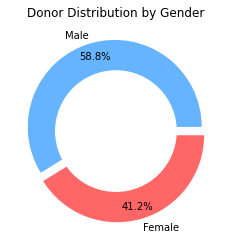

In [13]:
gender = ['Male','Female']
donor_dis = [78271,54769]
colors = ['#66b3ff','#ff6666']
explode=(0.05,0.05)
plt.pie(donor_dis, colors=colors, labels=gender,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
 
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
 
fig.gca().add_artist(centre_circle)
 
plt.title('Donor Distribution by Gender')
plt.show()

# Q12. Using loc, retrieve the race and time of aysytole of donors between indices 1001 and 2001.

In [14]:
retrieved_rows = donor.loc[1001:2001,['race','time_asystole']]
retrieved_rows

race       time_asystole
1001     White 2034-03-28 16:47:00
1002  Hispanic                 NaT
1003     White 2034-01-19 12:00:00
1004  Hispanic 2032-01-19 18:49:00
1005  Hispanic 2036-02-05 18:31:00
...        ...                 ...
1997  Hispanic 2037-05-19 23:10:00
1998  Hispanic                 NaT
1999     White 2034-11-20 21:21:00
2000  Hispanic 2034-02-04 15:00:00
2001     White 2035-06-15 05:58:00

[1001 rows x 2 columns]

# Q13. np.arange(1,31).reshape(6,5)
    1. Find array slicing to get the elements 1,2,8,30. 
    2. When the value is less than 9, print as 0,else print 99

In [15]:
arr = np.arange(1,31).reshape(6,5)
arr

array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10],
       [11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25],
       [26, 27, 28, 29, 30]])

In [16]:
sliced_arr = [arr[0,0],arr[0,1],arr[1,2],arr[-1,-1]]
print('array slicing to get the elements 1,2,8,30')
print(sliced_arr)

sliced_arr = np.array(sliced_arr)
new_arr = np.where(sliced_arr<9,0,99)
print('When the value is less than 9, print as 0,else print 99')
print(new_arr)

array slicing to get the elements 1,2,8,30
[1, 2, 8, 30]
When the value is less than 9, print as 0,else print 99
[ 0  0  0 99]


# Q14. Create subplots for the following data
x = np.arange(0, 10, 0.1)
y = np.sin(np.pi * x) + x 
using an object-oriented approach, and arrange the subplots in a 2x2 grid layout

Text(0.5, 1.0, 'plotting y3 = np.sin(np.pi*x)-x*x')

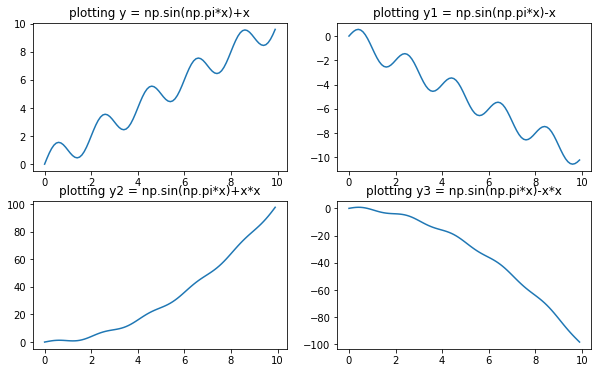

In [17]:
x = np.arange(0, 10, 0.1)
y = np.sin(np.pi * x) + x
y1 = np.sin(np.pi*x)-x
y2 = np.sin(np.pi*x)+(x*x)
y3 = np.sin(np.pi*x)-(x*x)
fig,axis = plt.subplots(2,2,figsize=(10,6),)
axis[0,0].plot(x,y)
axis[0,1].plot(x,y1)
axis[1,0].plot(x,y2)
axis[1,1].plot(x,y3)
axis[0,0].set_title('plotting y = np.sin(np.pi*x)+x')
axis[0,1].set_title('plotting y1 = np.sin(np.pi*x)-x')
axis[1,0].set_title('plotting y2 = np.sin(np.pi*x)+x*x')
axis[1,1].set_title('plotting y3 = np.sin(np.pi*x)-x*x')

# Q15. Create a box plot on any values in the dataset. Ensure that it is analytically correct.

<AxesSubplot:xlabel='race', ylabel='age'>

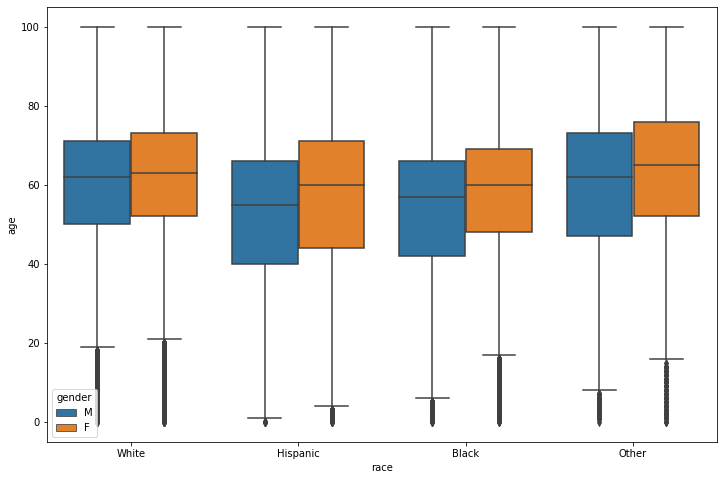

In [18]:
plt.figure(figsize=(12,8))
sns.boxplot(data=donor,x='race',y='age',hue='gender')
#This boxplot indicates that 50% of white males are aged b/w 50-70years and median age of white females in around 62 years.

# Q16. How many donors were registered in each Organ Procurement Organization?

In [19]:
opo_hosp.groupby('OPO')['PatientID'].count()

OPO
OPO1    32148
OPO2    16145
OPO3    12514
OPO4    33641
OPO5    15738
OPO6    22915
Name: PatientID, dtype: int64

# Q17. Calculate the average time between referral and procurement for each mechanism of death

In [20]:
# Merge DonorDetails and ReferralDetails based on PatientID
merged_data = pd.merge(donor, referral, on="PatientID", how="inner")

# Calculate the time difference between referral and procurement (in hours)
merged_data['time_diff_in_hours'] = merged_data.apply(
    lambda row: (row['time_procured'] - row['time_referred']).total_seconds() // 3600, axis=1
)

average_time = merged_data.groupby('mechanism_of_death')['time_diff_in_hours'].mean().reset_index().round(1)
# Display the results
print(average_time)

           mechanism_of_death  time_diff_in_hours
0                Asphyxiation               110.4
1                Blunt Injury               106.6
2              Cardiovascular               100.0
3   Death from Natural Causes                63.0
4                    Drowning               115.5
5           Drug Intoxication               103.8
6                  Electrical               111.1
7              Gun Shot Wound                94.8
8               Gunshot Wound                71.9
9              Natural Causes               105.9
10          None of the Above               100.6
11          None of the above                54.2
12                      Other                56.5
13                    Seizure               100.3
14                       Stab                96.1
15                     Stroke                85.9
16        Sudden Infant Death                95.2
17                    Unknown            -97003.0


# Q18. What % of all referrals are procured?

In [21]:
# Calculate total referrals and procured referrals
total_referrals = referral['PatientID'].nunique()
procured_referrals = referral['time_procured'].notna().sum()
# Calculate the percentage of procured referrals
percentage_procured = (procured_referrals / total_referrals) * 100
print(f"""
Total Referrals: {total_referrals}
Procured Referrals: {procured_referrals}
Percentage Procured: {percentage_procured:.1f}%
""")


Total Referrals: 133101
Procured Referrals: 9543
Percentage Procured: 7.2%



# Q19. Write a function to calculate the year of birth for each patient using year of referral as a base.

In [22]:
def calc_year_of_birth(patient_id):
    agecol = donor.loc[donor['PatientID'] == patient_id, 'age'].values[0]
    Refyear = referral.loc[referral['PatientID'] == patient_id, 'Referral_Year'].values[0]
    birth_year = Refyear - agecol
    return birth_year

# Calling the Function using Patient ID
calc_year_of_birth('OPO1_P155959')

1967.0

# Q20. How many patients have died of sepsis following drowning incidents?

In [23]:
# Calculate Patient Count based on Sepsis as Cause of Death and Drowning as Mechanism of Death
Patient_count = donor[(donor['causeofdeath'].str.contains('Sepsis', na=False)) & 
           (donor['mechanism_of_death'].str.contains('Drowning', na=False))].shape[0]

# Get Patient Details based on Sepsis as Cause of Death and Drowning as Mechanism of Death
Patient_Details = donor[donor['causeofdeath'].str.contains('Sepsis', na=False) & donor['mechanism_of_death'].str.contains('Drowning', na=False)]

# Print the results of Patient Details and Patient Count
#print(Patient_Details)
print(f"Number of patients died of Sepsis following Drowning: {Patient_count}")

Number of patients died of Sepsis following Drowning: 1


# Q21. What percentage of all procurements are actually transplanted?

In [24]:
# Calculate total Procurements and Transplanted Procurements
total_Procurements = referral['time_procured'].notna().sum()
Transplanted_Procurements = (referral['transplanted'] == 1).sum()

# Calculate the percentage of procured referrals
percentage_Transplanted = (Transplanted_Procurements / total_Procurements) * 100
# Print the results
print(f"Total Procurements: {total_Procurements}\n"
      f"Transplanted Procurements: {Transplanted_Procurements}\n"
      f"Percentage Transplanted: {percentage_Transplanted:.1f}%")

Total Procurements: 9543
Transplanted Procurements: 8972
Percentage Transplanted: 94.0%


# Q22. What is the ratio of referrals to procurements per year?

In [25]:
# Calculate Total Referrals and Total Procurements grouped by Year
Referrals_Group = referral.groupby("Referral_Year").size()
Procured_Group = referral.groupby("Procured_Year").size()
# Calculate ratio
Referrals_Procurement_Ratio = (Referrals_Group / Procured_Group).round(1)
# Display the result
print(f"Ratio of Referrals to Procurements per year: ")
print(Referrals_Procurement_Ratio)

Ratio of Referrals to Procurements per year: 
1987.0     NaN
2015.0    12.6
2016.0    12.0
2017.0    12.8
2018.0    14.3
2019.0    12.8
2020.0    15.2
2021.0    16.6
2022.0     NaN
dtype: float64


# Q23. How many referrals occurred in 2018?

In [26]:
No_Of_Referrals_2018 = (referral['Referral_Year'] == 2018).sum()
print(f"Number of Referrals in 2018 : {No_Of_Referrals_2018}")

Number of Referrals in 2018 : 19175


# Q24. Which hospital had the lowest rate of lung transplants? Procured but not transplanted

In [27]:
# Merge Outcomes and OPO_HospDetails based on PatientID
merged_data = pd.merge(outcomes, opo_hosp, on="PatientID", how="inner")
# Select only columns list where Lungs are Procured but not transplanted
Lung_Details = merged_data[
    (merged_data['outcome_lung_left'] == 'Recovered for Transplant but not Transplanted') | 
    (merged_data['outcome_lung_right'] == 'Recovered for Transplant but not Transplanted')]
#print(Lung_Details)

# Get the count of lung transplants which are Procured but not transplanted
Lung_transplant_counts = Lung_Details.groupby('HospitalID').size().reset_index(name='LungTransplantCount')

#Getting the Hospital wih Lowest rate
min_count = Lung_transplant_counts['LungTransplantCount'].min()

# Filter rows with the minimum count
hospitals_with_min_count = Lung_transplant_counts[Lung_transplant_counts['LungTransplantCount'] == min_count]

# Display the result.... The Answer shows all hospitals with Lowest rate of lung transplants
print("Hospital(s) with the Lowest rate of lung transplants(Procured but not transplanted):")
print(hospitals_with_min_count)

Hospital(s) with the Lowest rate of lung transplants(Procured but not transplanted):
     HospitalID  LungTransplantCount
0   OPO1_H10931                    1
1   OPO1_H11199                    1
2   OPO1_H15275                    1
3   OPO1_H15318                    1
5   OPO1_H18660                    1
6   OPO1_H21231                    1
9   OPO1_H23280                    1
11  OPO1_H26589                    1
14  OPO1_H27748                    1
16   OPO1_H3313                    1
17   OPO1_H5832                    1
18   OPO1_H8351                    1
20  OPO2_H14068                    1
21  OPO2_H14414                    1
22   OPO2_H3728                    1
23   OPO2_H5608                    1
24   OPO2_H5806                    1
25   OPO2_H6956                    1
26   OPO2_H8507                    1
27   OPO3_H1156                    1
28   OPO3_H2024                    1
29   OPO3_H4291                    1
30   OPO3_H6633                    1
31   OPO3_H9193            

# Q25. In donors where brain death occurred, what was the time difference between brain death and asystole?

In [28]:
#Taking out Brain death people 
Patient_Brain_Death = donor[donor['brain_death'] == 1]

# Dropping Null Values
Patient_Brain_Death=Patient_Brain_Death.dropna()

# Calculating Time difference in hours between Brain death time and Asystole
Patient_Brain_Death['time_diff_hours'] = Patient_Brain_Death.apply(
    lambda row: (row['time_brain_death'] - row['time_asystole']).total_seconds() // 3600, axis=1
)

# Select relevant columns for output
result = Patient_Brain_Death[['PatientID', 'time_brain_death', 'time_asystole', 'time_diff_hours']]

# Print the result
print(result)

           PatientID    time_brain_death       time_asystole  time_diff_hours
114     OPO1_P311852 2034-07-14 18:07:00 2034-07-15 14:15:00            -21.0
135     OPO1_P873659 2037-01-07 11:45:00 2037-01-08 08:20:00            -21.0
154     OPO1_P580294 2035-01-04 15:59:00 2035-01-04 23:36:00             -8.0
159     OPO1_P514268 2033-10-30 09:00:00 2033-10-30 18:15:00            -10.0
239     OPO1_P393068 2037-09-06 18:35:00 2037-09-09 15:44:00            -70.0
...              ...                 ...                 ...              ...
129973  OPO6_P316978 2033-06-07 19:20:00 2033-06-10 00:13:00            -53.0
130627  OPO6_P348278 2034-01-21 16:02:00 2034-01-21 16:02:00              0.0
131195  OPO6_P692465 2031-05-14 21:01:00 2031-05-14 23:00:00             -2.0
131656  OPO6_P821834 2033-04-12 15:07:00 2033-04-13 06:45:00            -16.0
132866  OPO6_P507978 2032-05-15 16:47:00 2032-05-15 16:47:00              0.0

[3518 rows x 4 columns]


# Q26. Which OPO recorded the highest calculated deaths in the year 2015?

In [29]:
#Group the Year by 2015 
Deaths_byYear_OPO1 = yearly[yearly['Year'] == 2015]

#Get entire row having highest calculated deaths in the year 2015
Max_Deaths_2015 = Deaths_byYear_OPO1.loc[Deaths_byYear_OPO1["mean calc deaths"].idxmax()]

#Prints Entire Row as Output
print("Entire Row Information:")
print(Max_Deaths_2015)

# Get only OPO information
OPO_HighestDeaths_2015 = Max_Deaths_2015["OPO"]
print("OPO with Highest Calculated Deaths in 2015:", OPO_HighestDeaths_2015)

Entire Row Information:
OPO                     OPO4
Year                    2015
mean calc deaths    3074.575
Name: 0, dtype: object
OPO with Highest Calculated Deaths in 2015: OPO4


# Q27. Create a pivot table shows organ-based outcome type as rows and outcome statuses as columns

In [30]:
#Selecting all Organs based on Pattern and their respective Output Statuses
melted_df = pd.melt(
    outcomes, 
    value_vars=[col for col in outcomes.columns if col.startswith('outcome_')],
    var_name='OrganType', 
    value_name='Outcome_Status'
)

#Creating the Pivot Table
pivot_table = pd.pivot_table(
    melted_df,
    values='Outcome_Status',
    index='OrganType',            # Organ Type as Rows
    columns='Outcome_Status',     # Outcome Statuses as Columns
    aggfunc='size',               # Getting the count of each status
    fill_value=0                  # Replace NaN with 0
)
print(pivot_table)

Outcome_Status        Recovered for Research  \
OrganType                                      
outcome_heart                            682   
outcome_intestine                        279   
outcome_kidney_left                      466   
outcome_kidney_right                     459   
outcome_liver                            533   
outcome_lung_left                       1182   
outcome_lung_right                      1246   
outcome_pancreas                         627   

Outcome_Status        Recovered for Transplant but not Transplanted  \
OrganType                                                             
outcome_heart                                                    21   
outcome_intestine                                                 4   
outcome_kidney_left                                            1252   
outcome_kidney_right                                           1300   
outcome_liver                                                   355   
outcome_lung_left     

# Q28. What is the average drop in procurement rate between each successive 4-hour period and visualize the trend.

time_procured
2001-05-22 08:00:00    1
2003-06-24 12:00:00    1
2028-10-08 12:00:00    1
2028-10-09 08:00:00    1
2028-10-17 00:00:00    1
                      ..
2038-03-31 04:00:00    1
2038-04-03 00:00:00    1
2038-04-08 08:00:00    1
2038-04-22 16:00:00    1
2038-05-18 12:00:00    1
Length: 7337, dtype: int64
Average drop in procurement rate between successive 4-hour periods: -1.20


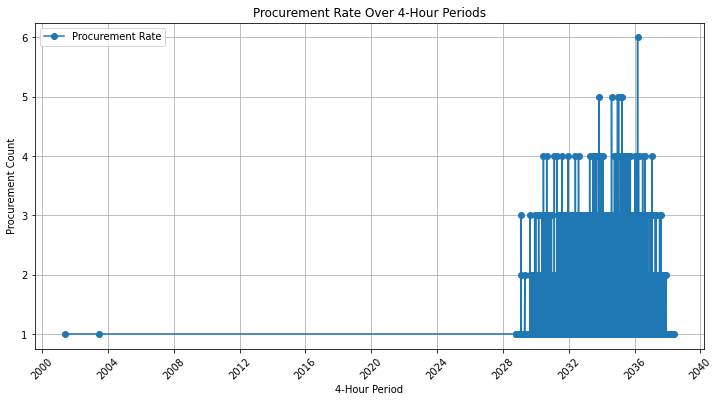

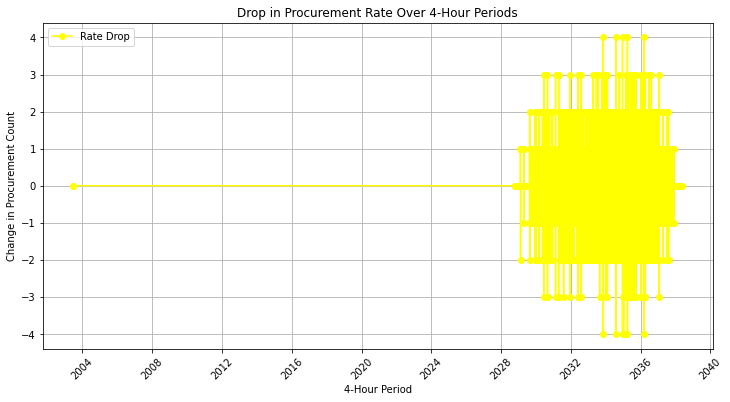

In [31]:
import matplotlib.pyplot as pl1
data = referral.dropna(subset=['time_procured'])

# Group data into 4-hour periods and calculate the count of procurements in each period
procurement_counts = data.groupby(referral['time_procured'].dt.floor('4h')).size()

#Print Procurement counts
print(procurement_counts)

# Calculate the drop in procurement rate between successive intervals
procurement_rate_diff = procurement_counts.diff()

# Calculate the average drop in procurement rate
average_drop = procurement_rate_diff[procurement_rate_diff < 0].mean()

# Print the average drop
print(f"Average drop in procurement rate between successive 4-hour periods: {average_drop:.2f}")

# Visualization of procurement rate trend
pl1.figure(figsize=(12, 6))
pl1.plot(procurement_counts.index, procurement_counts.values, marker='o', label='Procurement Rate')
pl1.title('Procurement Rate Over 4-Hour Periods')
pl1.xlabel('4-Hour Period')
pl1.ylabel('Procurement Count')
pl1.legend()
pl1.grid(True)
pl1.xticks(rotation=45)
pl1.show()

# Visualization of procurement rate drop trend
pl1.figure(figsize=(12, 6))
pl1.plot(procurement_rate_diff.index, procurement_rate_diff.values, marker='o', color='yellow', label='Rate Drop')
pl1.title('Drop in Procurement Rate Over 4-Hour Periods')
pl1.xlabel('4-Hour Period')
pl1.ylabel('Change in Procurement Count')
pl1.legend()
pl1.grid(True)
pl1.xticks(rotation=45)
pl1.show()


# Q29. How many deaths were registered with OPO 1? List them by year.

In [32]:
Deaths_byYear_OPO1 = yearly[yearly["OPO"] == "OPO1"]
print("Number of Deaths registered with OPO1 by Year: ")
print(Deaths_byYear_OPO1)

Number of Deaths registered with OPO1 by Year: 
     OPO  Year  mean calc deaths
30  OPO1  2015           2852.69
31  OPO1  2016           2954.13
32  OPO1  2017           3112.34
33  OPO1  2018           3019.04
34  OPO1  2019           3148.80
35  OPO1  2020           3236.50


# Q30. What percentage of all procurements are used for research?

In [33]:
#Getting all Procurements count
total_Procurements = len(outcomes)

#Getting the count of the occurance of particular string related to Research
search_string = 'Recovered for Research'
All_Research_Procurements = outcomes.applymap(lambda x: str(x).count(search_string)).sum().sum()
#print(f"The string '{search_string}' appears {All_Research_Procurements} times in the sheet.")

#Calculating the percentage of all procurements used for research
percentage_procured_Research = (All_Research_Procurements / total_Procurements) * 100

# Print the results
print(f"Total Procurements: {total_Procurements}")
print(f"Procured For Research: {All_Research_Procurements}")
print(f"Percentage Procured for Research: {percentage_procured_Research:.1f}%")

Total Procurements: 9534
Procured For Research: 5474
Percentage Procured for Research: 57.4%


# Q31. How many donors with a successful transplant died of a seizure?

In [34]:
# Merge DonorDetails and ReferralDetails based on PatientID
merged_data = pd.merge(donor, referral, on="PatientID", how="inner")

# Get No of donors with a successful transplant = 1 and cause of death = Seizure
Patient_count = merged_data[(merged_data['causeofdeath'].str.contains('Seizure', na=False)) & ((merged_data['transplanted'] == 1))].shape[0]

#Print the result
print(f"Number of Donors with a successful transplant died of a seizure : {Patient_count}")

Number of Donors with a successful transplant died of a seizure : 3


# Q32. Create a sunburst chart of age, race and any one outcome

In [35]:
# Merge data from 'donor' and 'outcomes' datasets based on 'PatientID'
merged_data = pd.merge(donor, outcomes, on="PatientID", how="inner")

# Handle null values by replacing them with "Unknown"
merged_data.fillna("Unknown", inplace=True)

# Create a Sunburst chart with 'age', 'race', and 'outcome_heart' columns
fig = px.sunburst(
    merged_data,
    path=['age', 'race', 'outcome_heart'],
    title="Age, Race, and Outcome Sunburst Chart"
)

# Display the Sunburst chart
fig.show()

# Q33. Which year had the maximum referrals? </b>


In [36]:
ref_yr = referral.groupby(["Referral_Year"])['PatientID'].count().reset_index()
ref_yr['Referral_Year'].loc[ref_yr['PatientID'].idxmax()]

2021

# Q34. How many organs are recovered for transplant but not transplanted?

In [37]:
total_organs = (outcomes == "Recovered for Transplant but not Transplanted").sum().sum()
print('total number of organs recovered for transplant but not transplanted is',total_organs)

total number of organs recovered for transplant but not transplanted is 3245


# <b> Q35.What are the 3 most frequent causes of death?</b>


In [38]:
Fre_value= donor.groupby("causeofdeath").size().nlargest(3).index.tolist()
print(f"The Most three Frequent cause of death :{Fre_value}")

The Most three Frequent cause of death :['Anoxia', 'Unknown', 'cerebrovascular accident']


# <b>Q36.How many transplants were registered under each OPO?</b>


In [39]:
Patient = referral.loc[referral["transplanted"]==1,"PatientID"]
patients_OPO = Patient.str[:4]
patients_OPO_df= pd.DataFrame({'OPO':patients_OPO})
grouped = list(patients_OPO_df.groupby(['OPO'])['OPO'].count() )
for index, value in enumerate(grouped):
    print(f"Number of transplants for OPO{index+1}:{value}")

Number of transplants for OPO1:2558
Number of transplants for OPO2:846
Number of transplants for OPO3:592
Number of transplants for OPO4:2265
Number of transplants for OPO5:1510
Number of transplants for OPO6:1201


# <b>Q37."Plot a stacked bar chart to show different procurement outcomes for organs - heart, liver, and pancreas.Label the bars with the actual numbers for each outcome."</b>


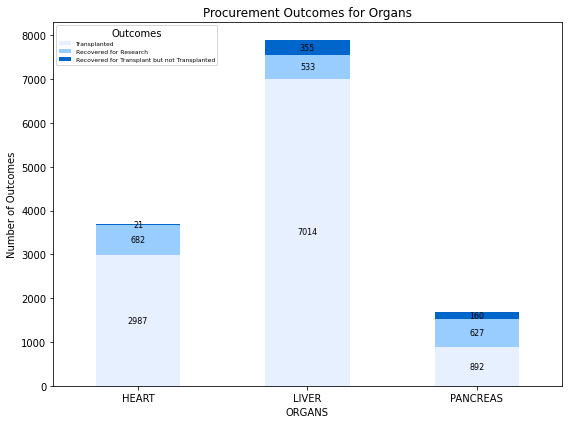

In [40]:
Outcomes_organ = outcomes[["outcome_heart", "outcome_liver", "outcome_pancreas"]].rename(
    columns={'outcome_heart': 'HEART', 'outcome_liver': 'LIVER', 'outcome_pancreas': 'PANCREAS'}
)
bar_counts = Outcomes_organ.apply(lambda col: col.value_counts()).transpose()
ax = bar_counts.plot(kind='bar', stacked=True, figsize=(8, 6), rot=0 ,color=['#e6f0ff','#99ccff','#0066cc'])
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=8 )
plt.title("Procurement Outcomes for Organs")
plt.ylabel("Number of Outcomes")
plt.xlabel("ORGANS")
plt.legend(title="Outcomes", loc='upper left',fontsize=6)
plt.tight_layout()
plt.show()

# Q38. What percentage of all transplants are lung transplants?

In [41]:
total_trasplants = (outcomes=='Transplanted').sum().sum()
lung_transplants = ((outcomes['outcome_lung_left']=='Transplanted').sum()) + ((outcomes['outcome_lung_right']=='Transplanted').sum())
print('Percentage of lung transplants is',round((lung_transplants*100)/total_trasplants,2))

Percentage of lung transplants is 14.54


# Q39. Which year had the maximum number of procurements?

In [42]:
Procured_time_year = referral.groupby(['Procured_Year'])['time_procured'].count()
Pro_value = Procured_time_year.max()
pro_year = Procured_time_year[Procured_time_year == Pro_value].index[0]
print(f"The year with the maximum procurements is {pro_year} with {Pro_value} procurements.")

The year with the maximum procurements is 2021.0 with 1670 procurements.


# Q40. Create a dataframe with date and time as columns, where the values are the referral time

In [43]:
referral['time_referred'] = pd.to_datetime(referral['time_referred'])

referral['Date'] = referral['time_referred'].dt.date
referral['Time'] = referral['time_referred'].dt.time

df_date_time = referral[['Date', 'Time']]
print(df_date_time.head())

         Date             Time
0  2033-06-21         06:49:25
1  2036-11-21  08:41:13.397000
2  2030-08-23  23:28:54.687000
3  2034-05-12  17:34:52.277000
4  2033-02-22  04:45:27.867000


# <b>Q41.Create a pair plot of the outcomes, using different outcome statuses as the hue.</b>

           OrganType                                 Outcome_Status  Count
0      outcome_heart                         Recovered for Research    682
1      outcome_heart  Recovered for Transplant but not Transplanted     21
2      outcome_heart                                   Transplanted   2987
3  outcome_intestine                         Recovered for Research    279
4  outcome_intestine  Recovered for Transplant but not Transplanted      4
Numeric columns for pairplot: ['Count']


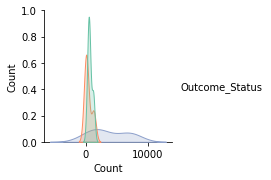

In [44]:
# Step 1: Melt the DataFrame
outcomes_melted = pd.melt(
    outcomes, 
    id_vars=['PatientID'],  # Keep PatientID as the identifier column
    value_vars=[col for col in outcomes.columns if col.startswith('outcome_')], 
    var_name='OrganType', 
    value_name='Outcome_Status'  # Outcome Status for each row
)

# Step 2: Group by OrganType and Outcome_Status, then count the occurrences
outcomes_grouped = outcomes_melted.groupby(['OrganType', 'Outcome_Status']).size().reset_index(name='Count')

# Step 3: Display the first few rows of the grouped DataFrame
print(outcomes_grouped.head())

# Step 4: Check if there are numeric columns
# Now that outcomes_grouped is a DataFrame, we can use select_dtypes
numeric_cols = outcomes_grouped.select_dtypes(include=['number']).columns.tolist()
print(f"Numeric columns for pairplot: {numeric_cols}")

# Step 5: Create a pairplot using the numeric columns
sns.pairplot(
    outcomes_grouped, 
    hue='Outcome_Status',  # Use 'Outcome_Status' for color encoding
    diag_kind='kde',        # KDE plots on the diagonal
    palette='Set2',         # Color palette for the hue
    vars=numeric_cols      # Explicitly pass the numeric columns for pairplot
)

# Show the plot
plt.show()

# Q42. What is the ratio of referrals to transplants by year?

In [45]:
Referrals_Group = referral.groupby("Referral_Year").size()
Transplanted_Procurements = (referral['transplanted'] == 1).sum()
Referrals_Transplanted_Ratio = (Referrals_Group / Transplanted_Procurements).round(2)
# Display the result
print(f"Ratio of Referrals to Transplants by year: ")
print(Referrals_Transplanted_Ratio)

Ratio of Referrals to Transplants by year: 
Referral_Year
2015    1.44
2016    1.43
2017    1.63
2018    2.14
2019    2.33
2020    2.79
2021    3.08
dtype: float64


# Q43. How many donors died from a drug overdose?

In [46]:
Drug_overdose_count = donor[donor["causeofdeath"].str.contains('Drug Overdose', case=False, na=False)].shape[0]
print(f"Number of Donors died from a 'Drug Overdose': {Drug_overdose_count}")

Number of Donors died from a 'Drug Overdose': 156


# Q44. Create a count plot to show distribution of patient-ages in any 2 mechanisms of death.

<AxesSubplot:xlabel='age_bins', ylabel='count'>

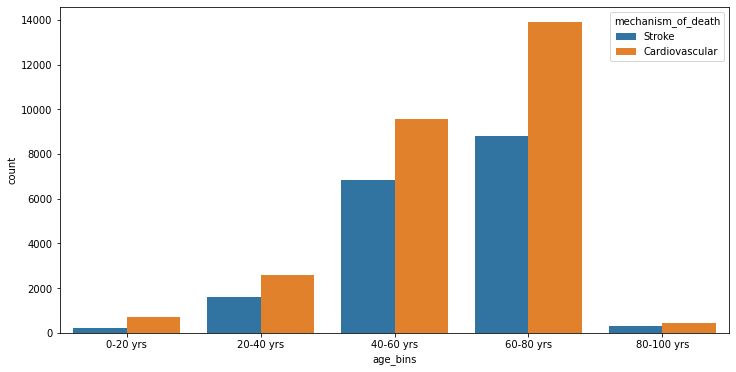

In [47]:
age_dis = donor[(donor['mechanism_of_death']=='Cardiovascular') | (donor['mechanism_of_death']=='Stroke')]

bins = [0,20,40,60,80,100]
labels = ['0-20 yrs', '20-40 yrs', '40-60 yrs', '60-80 yrs', '80-100 yrs']
age_dis['age_bins'] = pd.cut(age_dis['age'], bins=bins, labels=labels)

plt.figure(figsize=(12,6))
sns.countplot(data=age_dis,x='age_bins',hue='mechanism_of_death')

# Q45. Create a Waffle chart to show what percentage of total deaths belong to each mechanism

In [48]:
#Replicating donor and replacing the similar mechanism of death names
d_w = donor
d_w['mechanism_of_death'].replace('Death from Natural Causes','Natural Causes',inplace=True)
d_w['mechanism_of_death'].replace('Gun Shot Wound','Gunshot Wound',inplace=True)
d_w['mechanism_of_death'].replace('None of the Above','None of the above',inplace=True)

#Creating a dataframe to show percentage or total deaths grouped by mechanism
mech_df = d_w.groupby('mechanism_of_death')['PatientID'].count().reset_index()
mech_df['Percentage'] = round((mech_df['PatientID']*100)/133101,1)

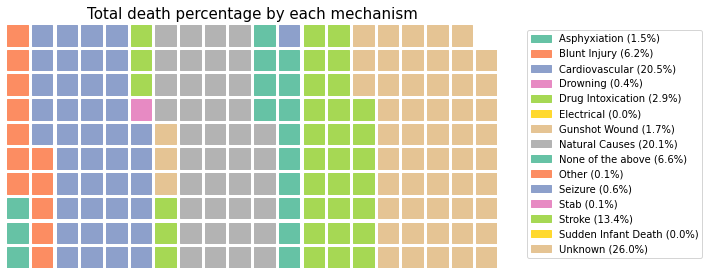

In [49]:
mechanism = {'Unknown': 'Unknown', 'Stroke': 'Stroke', 'None of the above': 'None of the above', 'Cardiovascular': 'Cardiovascular',
                'Drug Intoxication':'Drug Intoxication','Gunshot Wound':'Gunshot Wound','Blunt Injury':'Blunt Injury',
                'Natural Causes':'Natural Causes','Seizure':'Seizure','Drowning':'Drowning','Asphyxiation':'Asphyxiation',
                'Stab':'Stab','Sudden Infant Death':'Sudden Infant Death','Electrical':'Electrical','Other':'Other'}

cmap = cm.get_cmap('viridis') 

fig = plt.figure(
    FigureClass=Waffle, figsize=(10, 8),
    rows=10,
    columns=20,
    values=mech_df['Percentage'],
    title={"label": "Total death percentage by each mechanism", "loc": "center", "size": 15},
    labels=[f"{k} ({v:.1f}%)" for k, v in zip(mech_df['mechanism_of_death'], mech_df['Percentage'])],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.05, 1)}
)

plt.show()

# Q46. How many donors were registered under each hospital?

In [50]:
donors_by_hospital = opo_hosp.groupby('HospitalID')['PatientID'].count()
print(f"Donors registered by hospital is: \n{donors_by_hospital}")

Donors registered by hospital is: 
HospitalID
OPO1_H10301      4
OPO1_H10329    237
OPO1_H10338     16
OPO1_H10818      1
OPO1_H10931    113
              ... 
OPO6_H755        1
OPO6_H7673     249
OPO6_H7717     477
OPO6_H8617       1
OPO6_H8991     639
Name: PatientID, Length: 557, dtype: int64


# Q47. What is the predominant 'identified mechanism of death' among the youngest donors in the dataset.

In [51]:
bins = [0,20,40,60,80,100]
labels = ['0-20 yrs', '20-40 yrs', '40-60 yrs', '60-80 yrs', '80-100 yrs']

donor['age_bins'] = pd.cut(donor['age'], bins=bins, labels=labels)
patient_counts = donor.groupby(['age_bins','mechanism_of_death'])['PatientID'].count().reset_index()
patient_counts[patient_counts['age_bins']=='0-20 yrs'].sort_values('PatientID',ascending=False).head(1)

age_bins mechanism_of_death  PatientID
1  0-20 yrs       Blunt Injury       1212

# Q48. Show a bar plot of the number of patients by race?

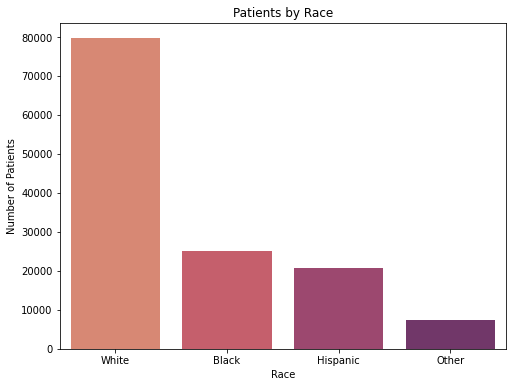

In [52]:
patients_by_race = donor['race'].value_counts().reset_index()
patients_by_race.columns = ['race', 'count']

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=patients_by_race, x='race', y='count',palette="flare")
plt.title('Patients by Race')
plt.xlabel('Race')
plt.ylabel('Number of Patients')
#plt.tight_layout()
plt.show()

## Q49. Perform an EDA of hosp_details using YDATA Profiling.

In [53]:
opo_hosp = pd.read_excel(file,'OPO_HospDetails')  # Example file

# Generate the profile report
profile = ProfileReport(opo_hosp, title="Hosp Details EDA Report", explorative=True)

# Save the report to an HTML file
profile.to_file("hosp_details_eda_report.html")

# Display the report in a Jupyter Notebook (optional)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Q50. In how many cases were the relatives approached for consent vs how many were authorized?

In [54]:
relatives_approached = referral['Approached Relatives'][referral['Approached Relatives']==1].sum()
authorized_by_family = referral['Authorized By Family'][(referral['Approached Relatives']==1)&(referral['Authorized By Family']==1)].sum()

print("Realtives approached =", relatives_approached)
print("Authorized by Family =",authorized_by_family)

Realtives approached = 19551
Authorized by Family = 11962


# Q51. Which OPO recorded the lowest calculated deaths in any year?

In [55]:
yearly[yearly['mean calc deaths']==min(yearly['mean calc deaths'])]

OPO  Year  mean calc deaths
25  OPO3  2016           656.265

## Q52. Plot the Density Chart for Cause of Death- Seizure against any other variable of your choice

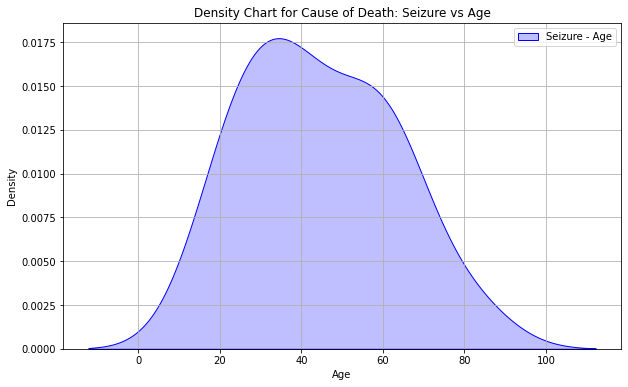

In [56]:
seizure_data = donor[donor['causeofdeath'] == 'Seizure']

# Choosing age as another variable for the comparison
plt.figure(figsize=(10, 6))

# Plotting the Density Chart (KDE)
sns.kdeplot(data=seizure_data, x='age', fill=True, color='blue', label='Seizure - Age')

# Customize the plot
plt.title('Density Chart for Cause of Death: Seizure vs Age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

## Q53. Display a correlation matrix showing count of donors in age group vs cause of death

In [57]:
donors_group = donor.groupby(['age', 'causeofdeath']).size().reset_index(name='Count')
#print(donors_group)

pivot_table = donors_group.pivot(index='age', columns='causeofdeath', values='Count').fillna(0)
#print("\nPivot Table:")
#print(pivot_table)

# Calculate correlation matrix
correlation_matrix = pivot_table.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
causeofdeath                  AIDS  Aneurysm    Anoxia  Arrhythmia       CHF  \
causeofdeath                                                                   
AIDS                      1.000000 -0.067747  0.086837   -0.066945 -0.018969   
Aneurysm                 -0.067747  1.000000  0.477978    0.231478  0.467009   
Anoxia                    0.086837  0.477978  1.000000    0.348125  0.828416   
Arrhythmia               -0.066945  0.231478  0.348125    1.000000  0.497262   
CHF                      -0.018969  0.467009  0.828416    0.497262  1.000000   
...                            ...       ...       ...         ...       ...   
drowning                 -0.062292 -0.086626 -0.181959   -0.082247 -0.158754   
hanging                   0.230609  0.175091 -0.029474    0.001664 -0.145422   
other                     0.161382  0.296084  0.714819    0.182841  0.394693   
smoke inhalation         -0.057323 -0.079715 -0.013545   -0.075685 -0.026836   
thoracic aortic ane

## Q54. Connect to sql and write a query to find all donors who's cause of death is unknown

In [58]:
# Database connection parameters
db_params = {
    'dbname': 'OrganDonor',
    'user': 'postgres',
    'password': 'ankubha@0206',
    'host': 'Localhost',
    'port': '5432'  # Default PostgreSQL port is 5432
}

try:
    # Connect to PostgreSQL
    connection = psycopg2.connect(**db_params)
    cursor = connection.cursor()

    # Write SQL query to find donors with unknown cause of death
    query = """
    select PatientID,causeofdeath from public.Donor where causeofdeath = 'Unknown';
    """

    # Execute the query
    cursor.execute(query)

    # Fetch results
    results = cursor.fetchall()

    # Optionally, convert results to a Pandas DataFrame for better visualization
    columns = [desc[0] for desc in cursor.description]  # Get column names
    donors_df = pd.DataFrame(results, columns=columns)

    print("Donors with unknown cause of death:")
    print(donors_df)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the connection
    if connection:
        cursor.close()
        connection.close()

Donors with unknown cause of death:
          patientid causeofdeath
0      OPO1_P155959      Unknown
1      OPO1_P297347      Unknown
2      OPO1_P187209      Unknown
3      OPO1_P867460      Unknown
4      OPO1_P810329      Unknown
...             ...          ...
26775  OPO1_P549364      Unknown
26776  OPO1_P284978      Unknown
26777  OPO1_P850186      Unknown
26778  OPO1_P869645      Unknown
26779  OPO1_P987954      Unknown

[26780 rows x 2 columns]


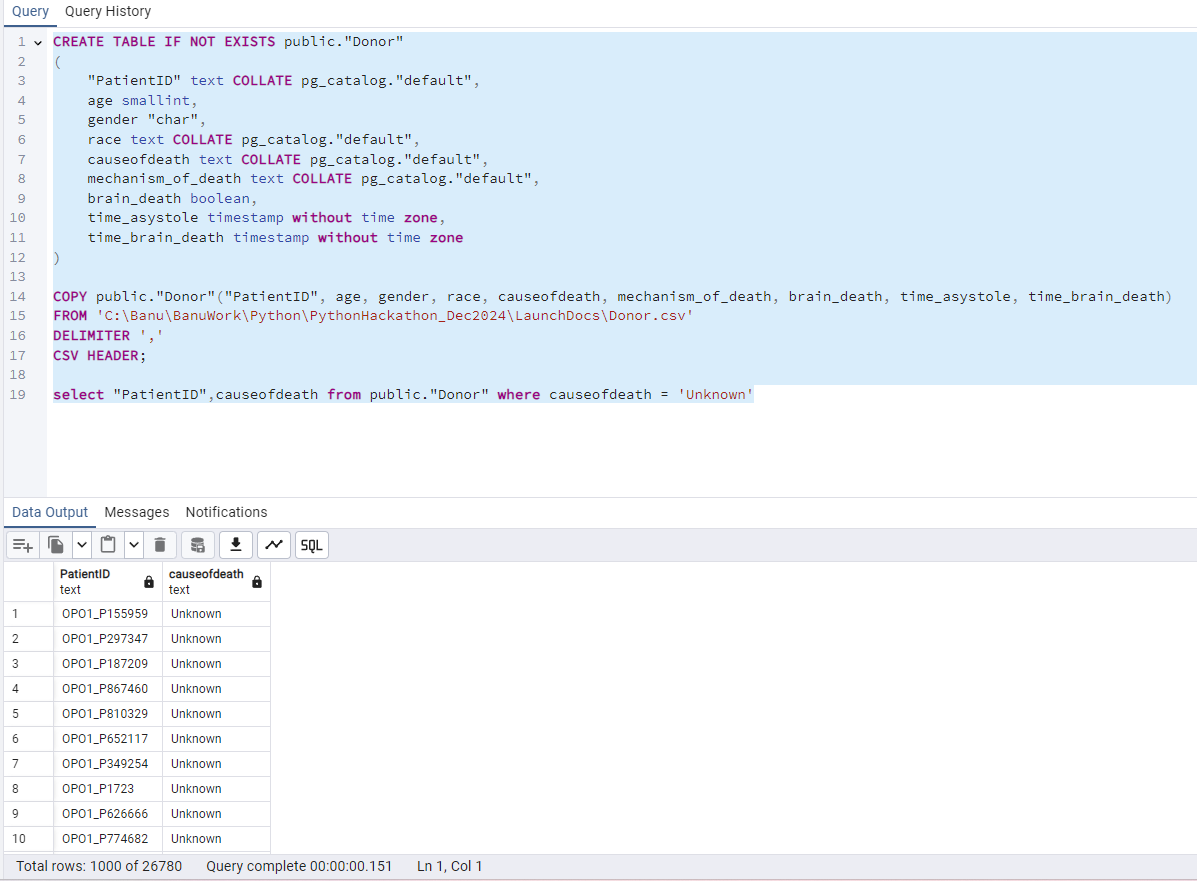

In [59]:
from IPython.display import Image
Image(filename = '/Users/SQLConnection_Query.png')

## Q55. Who was the youngest white donor registered?

In [60]:
youngest_donor = donor[(donor['age']==min(donor['age'])) & (donor['race']=='White')]
print("The youngest white donors registered were :",list(youngest_donor["PatientID"]))

The youngest white donors registered were : ['OPO1_P317726', 'OPO1_P957148', 'OPO1_P424777', 'OPO1_P221266', 'OPO1_P446649', 'OPO3_P635371', 'OPO4_P266590', 'OPO4_P445728', 'OPO4_P556895', 'OPO4_P563890', 'OPO4_P212033', 'OPO4_P87683', 'OPO4_P813015', 'OPO4_P424335', 'OPO4_P762063', 'OPO4_P890398', 'OPO6_P7734', 'OPO1_P311956', 'OPO1_P482290', 'OPO3_P449835', 'OPO6_P104767']


## Q56. what is the average time difference between brain death and time_approached

In [61]:
#Creating a df and dropping the rows that have null values
braindeath = donor[['PatientID', 'time_brain_death']]
timeapp = referral[['PatientID','time_approached']]
braindeath_timeapp_merge = pd.merge(braindeath,timeapp)
braindeath_timeapp_merge.dropna(axis=0,inplace=True)

#Calculating the avg time difference
braindeath_timeapp_merge['timediff'] = (pd.to_datetime(braindeath_timeapp_merge['time_brain_death'])-pd.to_datetime(braindeath_timeapp_merge['time_approached'])).dt.total_seconds()/3600
print('Average time between time approached and brain death in hours is: ',round(braindeath_timeapp_merge['timediff'].mean(),2),'hrs')

Average time between time approached and brain death in hours is:  50.94 hrs


## Q57. Plot a graph to show the distribution of age

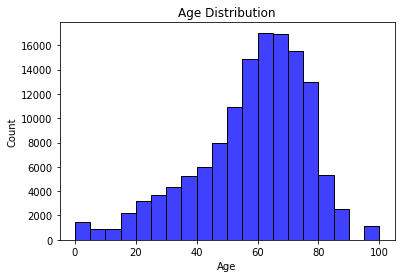

In [62]:
sns.histplot(donor['age'], bins=20, kde=False, color='blue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

## Q58. Plot a 3-D graph using any set of random values chosen by you

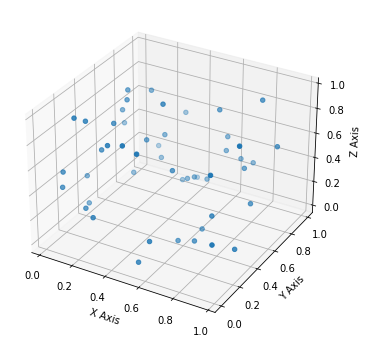

In [63]:
np.random.seed(42)
x = np.random.rand(50)
y = np.random.rand(50)
z = np.random.rand(50)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, cmap='viridis', marker='o')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.show()

## Q59. What % of the dataset is male vs female?

In [64]:
total_people=(donor.shape)[0]
num_males = donor[donor["gender"]== "M"]["gender"].count()
per_male= round((num_males/total_people)*100, 2)
num_females=donor[donor["gender"]== "F"]["gender"].count()
per_female= round((num_females/total_people)*100, 2)
print("Percentage of the males vs females in dataset is ", per_male,':',per_female)

Percentage of the males vs females in dataset is  58.81 : 41.15


## Q60. How many patients of each race are listed under an Unknown cause of death?

In [65]:
donor[donor['causeofdeath']=="Unknown"].groupby('race')['PatientID'].count()                                              

race
Black        4970
Hispanic     4181
Other        1635
White       15994
Name: PatientID, dtype: int64

## Q61. Display all records where approached time is more than 2 days after referral time

In [66]:
filtered_df = referral[referral['time_approached'] - referral['time_referred'] > pd.Timedelta(days=2)]

result = filtered_df[['PatientID', 'time_approached', 'time_referred']]

print(result)

           PatientID     time_approached           time_referred
25      OPO1_P648384 2035-03-11 17:28:00 2035-03-09 13:19:38.767
37      OPO1_P112469 2034-10-20 14:50:00 2034-10-18 02:59:38.310
70      OPO1_P278912 2035-02-02 11:35:00 2035-01-29 04:55:52.807
112     OPO1_P610885 2029-10-31 15:30:00 2029-10-29 13:03:00.000
123     OPO1_P420462 2036-12-30 16:11:00 2036-12-27 10:28:23.860
...              ...                 ...                     ...
132849   OPO6_P10911 2033-07-18 16:30:00 2033-07-02 22:38:00.000
132879   OPO6_P91502 2029-05-29 22:30:00 2029-05-27 11:58:00.000
132930  OPO6_P332293 2033-11-17 22:40:00 2033-11-13 17:18:00.000
132974  OPO6_P313521 2035-07-27 13:00:00 2035-07-24 03:48:00.000
133010  OPO6_P925470 2035-05-28 18:16:00 2035-05-24 05:12:00.000

[8141 rows x 3 columns]


## Q62. Display a donut chart of race and explode the wedge with the maximum patients

race
Black       25180
Hispanic    20727
Other        7506
White       79688
Name: PatientID, dtype: int64


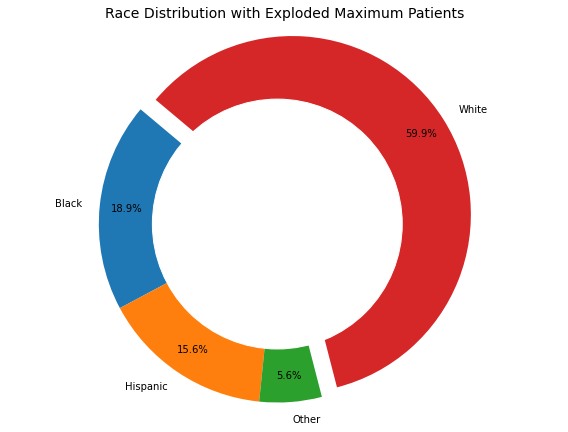

In [67]:
donor["PatientID"] = pd.to_numeric(donor["PatientID"], errors="coerce")

race_counts = donor.groupby("race")["PatientID"].size()

print(race_counts)

if race_counts.empty:
    print("No data available to plot.")
else:
    # Prepare data for the donut chart
    sizes = race_counts.values
    labels = race_counts.index

    # Find the race with the maximum patients
    max_race = race_counts.idxmax()
    max_index = list(race_counts.index).index(max_race)

    # Explode the slice with the maximum patients
    explode = [0.1 if i == max_index else 0 for i in range(len(labels))]

    # Create the donut chart
    fig, ax = plt.subplots(figsize=(8, 6))
    wedges, texts, autotexts = ax.pie(
        sizes, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=140, 
        explode=explode, 
        pctdistance=0.85
    )

    # Add a white circle for the donut effect
    center_circle = plt.Circle((0, 0), 0.70, color='white')
    plt.gca().add_artist(center_circle)

    # Display the chart
    plt.title("Race Distribution with Exploded Maximum Patients", fontsize=14)
    plt.axis('equal')  # Equal aspect ratio
    plt.tight_layout()
    plt.show()

## Q63. Plot a graph by multiplotting on the same canvas  (Take any set of x & y values)

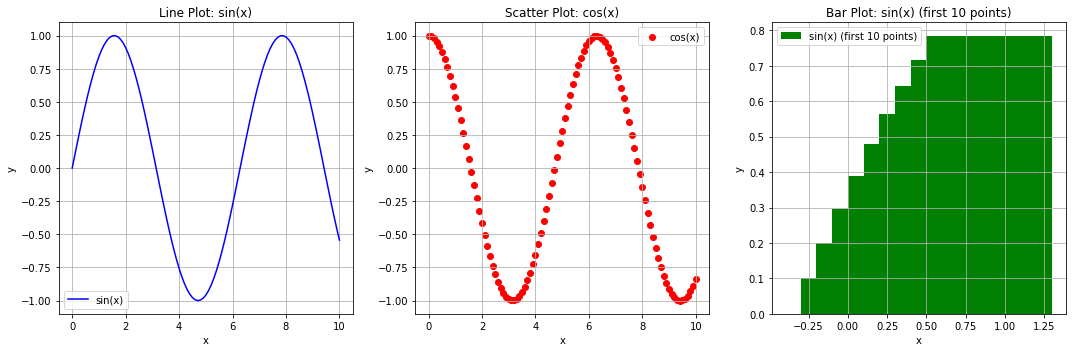

In [68]:
x = np.arange(0, 10.1, 0.1)
y = np.sin(x)
y2 = np.cos(x)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(x, y, color='blue', label='sin(x)')
axes[0].set_title('Line Plot: sin(x)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(x, y2, color='red', label='cos(x)')
axes[1].set_title('Scatter Plot: cos(x)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].legend()
axes[1].grid(True)

axes[2].bar(x[:10], y[:10], color='green', label='sin(x) (first 10 points)')
axes[2].set_title('Bar Plot: sin(x) (first 10 points)')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()

## Q64. Replace all null values in 'Procured_year' to 1900

In [69]:
referral["Procured_Year"]= referral["Procured_Year"].replace(np.nan, 1900)
referral[referral["Procured_Year"] == 1900].head()

PatientID  Approached Relatives  Authorized By Family  Cross_Clamped  \
0  OPO1_P320866                     0                     0              0   
1  OPO1_P549364                     0                     0              0   
2  OPO1_P536997                     1                     0              0   
3  OPO1_P463285                     0                     0              0   
4  OPO1_P284978                     0                     0              0   

   transplanted  Tissue_Referral  Eye_Referral           time_referred  \
0             0                1             1 2033-06-21 06:49:25.000   
1             0                1             1 2036-11-21 08:41:13.397   
2             0                1             1 2030-08-23 23:28:54.687   
3             0                1             1 2034-05-12 17:34:52.277   
4             0                1             1 2033-02-22 04:45:27.867   

  time_approached time_authorized time_procured Referral_DayofWeek  \
0             NaT             NaT           NaT            Tuesday   
1             NaT             NaT           NaT             Sunday   
2             NaT             NaT           NaT             Friday   
3             NaT             NaT           NaT             Monday   
4             NaT             NaT           NaT             Friday   

   Referral_Year  Procured_Year  datediff        Date             Time  
0           2018         1900.0       NaN  2033-06-21         06:49:25  
1           2021         1900.0       NaN  2036-11-21  08:41:13.397000  
2           2015         1900.0       NaN  2030-08-23  23:28:54.687000  
3           2019         1900.0       NaN  2034-05-12  17:34:52.277000  
4           2018         1900.0       NaN  2033-02-22  04:45:27.867000

# Q65. List any 10 donors that are not there in the outcomes sheet

In [70]:
#Compare Patient ID column in Donordetails and Outcomes sheet.
donor_missing= donor[~donor['PatientID'].isin(outcomes['PatientID'])]
print("10 donors missing in outcomes sheet are: ")
donor_missing.head(10)

10 donors missing in outcomes sheet are: 


PatientID   age gender      race              causeofdeath  \
0        NaN  54.0      M     White                   Unknown   
1        NaN  78.0      M  Hispanic                   Unknown   
2        NaN  57.0      M  Hispanic                    Anoxia   
3        NaN  78.0      F     Black  cerebrovascular accident   
4        NaN  70.0      F     White                   Unknown   
5        NaN  51.0      M  Hispanic                   Unknown   
6        NaN  69.0      F     White                   Unknown   
7        NaN  72.0      F  Hispanic                   Unknown   
8        NaN  59.0      F     White                    Anoxia   
9        NaN  61.0      M     Black                    Anoxia   

  mechanism_of_death  brain_death       time_asystole time_brain_death  \
0            Unknown            0 2036-01-02 18:26:00              NaT   
1            Unknown            0 2031-12-24 14:06:00              NaT   
2            Unknown            0 2034-05-11 00:00:00              NaT   
3             Stroke            0 2035-06-14 14:18:00              NaT   
4            Unknown            0 2034-02-18 18:50:00              NaT   
5            Unknown            0 2034-10-26 03:30:00              NaT   
6            Unknown            0 2035-10-24 00:00:00              NaT   
7  None of the above            0 2032-09-27 02:11:00              NaT   
8     Cardiovascular            0 2037-10-30 17:25:00              NaT   
9             Stroke            0 2031-01-17 10:11:00              NaT   

    age_bins  
0  40-60 yrs  
1  60-80 yrs  
2  40-60 yrs  
3  60-80 yrs  
4  60-80 yrs  
5  40-60 yrs  
6  60-80 yrs  
7  60-80 yrs  
8  40-60 yrs  
9  60-80 yrs

# Q66. Using stack/unstack functions show the number of donors for each outcome type and cause of death

In [71]:
donor = pd.read_excel(file,'DonorDetails')
outcomes_melted = pd.melt(
    outcomes, 
    id_vars=['PatientID'],  # Keep PatientID as the identifier column
    value_vars=[col for col in outcomes.columns if col.startswith('outcome_')], 
    var_name='OrganType', 
    value_name='Outcome_Status'
)

merged_data = pd.merge(outcomes_melted, donor, on="PatientID", how="inner")

# Step 1: Group by OutcomeType and CauseOfDeath, then count the number of donors
donor_counts = merged_data.groupby([outcomes_melted['OrganType'], 'causeofdeath']).size()

# Step 2: Unstack the data to get cause of death as columns
donor_counts_unstacked = donor_counts.unstack(fill_value=0)

# Step 3: Stack back to a long format if needed
donor_counts_stacked = donor_counts_unstacked.stack()

# Display the results
print("Unstacked Donor Counts:")
print(donor_counts_unstacked)

print("\nStacked Donor Counts (Long Format):")
print(donor_counts_stacked)

Unstacked Donor Counts:
causeofdeath          Aneurysm  Anoxia  CHF  CNS Tumor  Cardiac Arrest  \
OrganType                                                                
outcome_heart                0    2872    0         40             144   
outcome_intestine            8    3350    0         24              80   
outcome_kidney_left          0    3778    0         24             168   
outcome_kidney_right         0    4086    8         40              24   
outcome_liver                0    3048    0         64             160   
outcome_lung_left            0    3406    0         32               8   
outcome_lung_right           0    4286    0          8               0   
outcome_pancreas             0    3622    0         40             176   

causeofdeath          Drowning  Drug Overdose  ESLD  Exsanguination  \
OrganType                                                             
outcome_heart               16              0     0               0   
outcome_intestine     

# Q67. plot a time series line graph showing yearly calculated deaths. Color each line by OPO ID

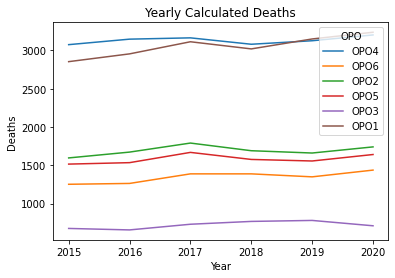

In [72]:
sns.lineplot(data=yearly,x=yearly["Year"],y=yearly["mean calc deaths"],hue=yearly["OPO"])
plt.xlabel("Year")
plt.ylabel("Deaths")
plt.title("Yearly Calculated Deaths")
plt.show()

# Q68. Create any two 2-dimensional arrays and multiply them. Display the resulting array

In [73]:
import numpy as np
# Create two 2D arrays
arr1= np.array([[2,5],[4,7]])
arr2= np.array([[8,3],[7,3]])
# Multiply the arrays
result= np.dot(arr1,arr2)
print(result)

[[51 21]
 [81 33]]


# Q69. Using a bar chart, which mechnism of death had the lowest count of donors?

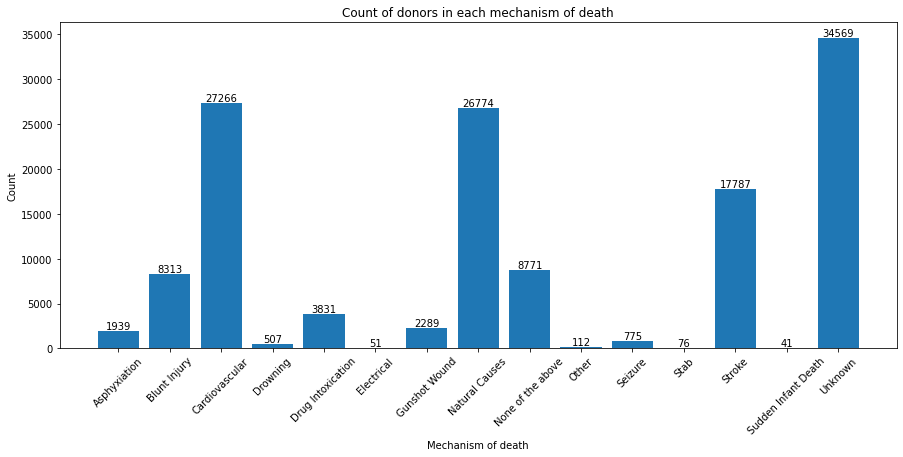

<Figure size 1080x432 with 0 Axes>

Clearly, the lowest count donors were those who died of Sudden Infant Death


In [74]:
#Replicating donor and changing the names of same mechanisms
d_bc = donor
d_bc['mechanism_of_death'].replace('Death from Natural Causes','Natural Causes',inplace=True)
d_bc['mechanism_of_death'].replace('Gun Shot Wound','Gunshot Wound',inplace=True)
d_bc['mechanism_of_death'].replace('None of the Above','None of the above',inplace=True)

#Creating a dataframe to calculate donor count by mechanism
ddata = d_bc.groupby('mechanism_of_death')['PatientID'].count().reset_index()

cat = list(ddata['mechanism_of_death'])
height = list(ddata['PatientID'])
fig,ax = plt.subplots(figsize=(15,6))
bar_chart = ax.bar(cat,height)
ax.bar_label(bar_chart)

# Add title and labels
plt.title("Count of donors in each mechanism of death")
plt.xlabel("Mechanism of death")
plt.ylabel("Count")

# Show the plot
plt.figure(figsize=(15,6))
ax.tick_params(axis='x', labelrotation=45) 
plt.show()
print('Clearly, the lowest count donors were those who died of Sudden Infant Death')

# Q70. Using arrays and loops find the number of patients who were referred in the month of July

In [75]:
# Convert referral time to datetime object
referral["time_referred"]= pd.to_datetime(referral["time_referred"])
# Specify July month
target_month= 7
# Find the patients referred in July
count=0
for index, row in referral.iterrows():
    if row["time_referred"].month == target_month:
        count+=1
print("Number of patients referred in July: ", count)

Number of patients referred in July:  11391


# Q71. Which year recorded the highest number of organ procurements from patients who died due to stroke as the mechanism of death?
Display this information using a bar chart.

Text(0.5, 1.0, 'According to this bar chart, max number of organs procured from patients who died due to stroke occured in 2019.')

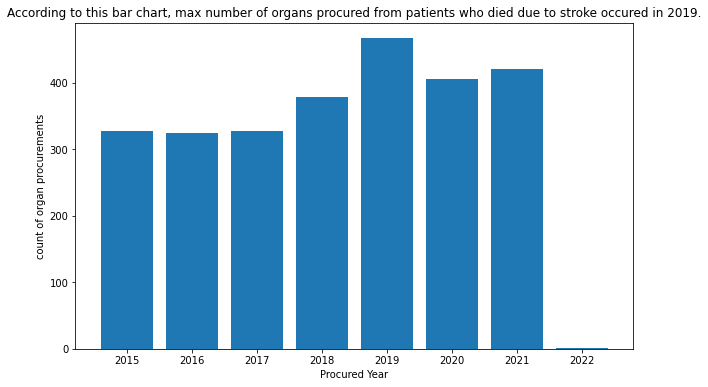

In [76]:
donor = pd.read_excel(file,'DonorDetails')
referral = pd.read_excel(file,"ReferralDetails")
#Creating a merged dataframe with procured year and donor information
proc_df = referral[['PatientID','Procured_Year']]
merged_donor = pd.merge(donor,proc_df,on=['PatientID'])

#Creating another dataframe with number of procurements in each year from only Stroke as mechanism of death
organ_proc = merged_donor[merged_donor['mechanism_of_death']=='Stroke'].groupby('Procured_Year')['PatientID'].count().reset_index()

plt.figure(figsize=(10,6))
plt.bar(x=organ_proc['Procured_Year'],height=organ_proc['PatientID'],)
plt.xlabel('Procured Year')
plt.ylabel('count of organ procurements')
plt.title('According to this bar chart, max number of organs procured from patients who died due to stroke occured in 2019.')

# Q72. Which organ has the highest chance of being successfully transplanted

In [77]:
search_str= 'Transplanted'
# Check the frequency of string in each column
frequency= outcomes.apply(lambda col: col.value_counts().get(search_str,0))
#Find the column with maximum frequency
max_freq_col= frequency.idxmax()
print(f"Organ with highest chance of being successfully transplanted is: {max_freq_col}")

Organ with highest chance of being successfully transplanted is: outcome_kidney_left


# Q73. Create a WordCloud Chart with any column of your choice


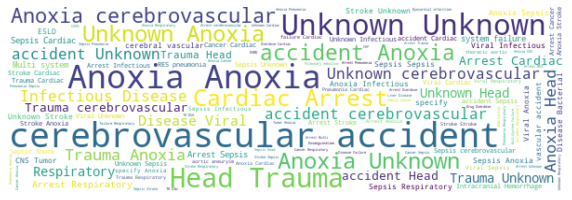

In [78]:
#Select the column
text=  ' '.join(donor["causeofdeath"].astype(str))
#Create worldcloud chart
wordcloud= WordCloud(width=600,height=200,background_color='white').generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# Q74. Group donors by age into 7 groups using the binning method. Show counts under each bin

In [79]:
# Define the age bins
bins=[0,10,20,40,50,70,80,100]
# Create column for binned ages
donor['age_group']= pd.cut(donor['age'], bins= bins, right=False)
# Show count under each bin
donor.groupby('age_group')['PatientID'].count()

age_group
[0, 10)       2357
[10, 20)      3091
[20, 40)     16541
[40, 50)     13931
[50, 70)     59730
[70, 80)     28477
[80, 100)     7785
Name: PatientID, dtype: int64

# Q75. "Can donors who die from cardiac arrest successfully donate their hearts for transplantation? 
Provide data and evidence from the given dataset to support your answer."

In [80]:
# Filter Donors from donordetails
df1= donor["causeofdeath"]
# Filter Donors from outcomes
df2= outcomes["outcome_heart"]
# Check for both the conditions to be true
result= (df1== "Cardiac Arrest")&(df2== "Transplanted")
data= donor[result]
print(data)
print('There is no patient who died of cardiac arrest and had their hearts transpanted')

Empty DataFrame
Columns: [PatientID, age, gender, race, causeofdeath, mechanism_of_death, brain_death, time_asystole, time_brain_death, age_group]
Index: []
There is no patient who died of cardiac arrest and had their hearts transpanted


# Q76. Which organ has the highest frequency of procurement.

In [81]:
# Find non null count of each column in outcome sheet
non_null_counts= outcomes.notnull().sum()
# exclude patientID column 
non_null_counts_excluded= non_null_counts[1:]
# Column with maximum non null values
col_max_nonnull = non_null_counts_excluded.idxmax()
print(f"Organ with highest frequency of procurement is: {col_max_nonnull}")

Organ with highest frequency of procurement is: outcome_kidney_right


# Q77. Using loops, create a multiplication table for the number 8 

In [82]:
count= 1
number= 8
while count<=10:
    result= number*count
    print(f"{number}*{count}={result}")
    count+=1

8*1=8
8*2=16
8*3=24
8*4=32
8*5=40
8*6=48
8*7=56
8*8=64
8*9=72
8*10=80


# Q78. Display random data by splitting it into 4 quartiles and labeling the quartiles.

In [83]:
# Generate random data
data = np.random.randn(80)
# calculate quartiles
quartiles = np.quantile(data,[0.25,0.5,0.75])
# Label the quartiles
df= pd.DataFrame(data,columns=['Data'])
def label_quartile(value,quartiles):
    if value<=quartiles[0]:
        return'Q1'
    elif value<=quartiles[1]:
        return'Q2'
    elif value<=quartiles[2]:
        return'Q3'
    else:
        return'Q4'
# Apply the function
df['Quartile']= df['Data'].apply(label_quartile, args= (quartiles,))
print(df)

        Data Quartile
0  -0.192361       Q2
1   0.301547       Q3
2  -0.034712       Q2
3  -1.168678       Q1
4   1.142823       Q4
..       ...      ...
75 -1.514847       Q1
76 -0.446515       Q2
77  0.856399       Q4
78  0.214094       Q3
79 -1.245739       Q1

[80 rows x 2 columns]


# Q79.Display all details of the oldest female patient

In [84]:
# Filter female patients
female_patient= donor[donor['gender']=='F']
# Fine oldest female
oldest_female= female_patient.loc[female_patient['age'].idxmax()]
print(oldest_female)

PatientID                     OPO1_P26983
age                                 100.0
gender                                  F
race                                Black
causeofdeath                      Unknown
mechanism_of_death                Unknown
brain_death                             0
time_asystole         2037-01-09 15:00:00
time_brain_death                      NaT
age_group                             NaN
Name: 290, dtype: object


# Q80. Create a point Plot on Age against Cardiac arrest.

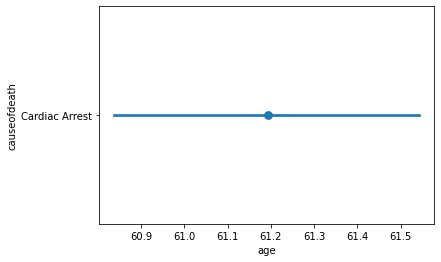

In [85]:
cardiac_arrest= donor[donor['causeofdeath']=='Cardiac Arrest']
sns.pointplot(data= cardiac_arrest,x='age',y='causeofdeath')
plt.show()